<img src="./stock.jpg" />

## Introduction and Data

The allure of predicting financial markets attracts the attention of some of America's most brilliant minds and fuels a massive industry. However, this lofty goal is more of a chimera as roughly 2/3 of actively managed funds fail to beat a benchmark fund like the S&P 500 on any give year and less than 5$\%$ can accomplish that feat consistently.  Nevertheless, there remains an insatiable desire to discover any possible edge to maximize gains and minimize drawdowns.

I, personally, have long been captivated by what seem to be coordinated movements in the markets that result from the combined outcomes of individual actors working in their own self interest.  In my trading I use technical indicators like moving average crossovers, Bollinger bands, and relative strength indicators.  I like this approach because I don't have to know why the market act the way it does; I simply want to identify behaviors that have a high probabilility of leading to price movements, either up or down.  Separating myself from the implications of job reports, Fed moves, and earnings is freeing since I only really need information encoded in charts, and it has been effective.

Originally, the analysis outlined here was not meant to be shared publically.  It is simply the product of me poking around at historical S&P 500 data on my own, using it to practice fitting ARIMA models, and to make predictions with support vector machines, so it is fairly informal.  Since it produced some interesting results, I figured it would be worth distributing for those who want to do similar tasks.  I also provide some commentary (ramblings) which began as notes.  I'm always trying to learn from those around me, do drop me a quick email if you have any thoughts on this work!

My general philosphy is to try to catch significant changes in the market.  As a grad student, most of my time and effort is spent doing research and *trying* to have a life.  Consequently, I don't have the ability to dissect the market second-by-second and really only want to capture price movements in the markets that last several weeks, at a minimum.  This is reflected in the subsequent analysis.

Let's begin by importing functions we will need.  Typically, I like to package my models in external routines to help with abstraction and code recyling, but here everything is contained within the notebook.

In [1]:
import pandas as pd
import numpy as np
import datetime
import itertools as itertools
import statsmodels.api as sm

from sklearn.svm import SVC
from  sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import uniform
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
%matplotlib inline
import warnings

Rather than pull data from the internet, I've downloaded historical S&P 500 data that contains the daily volume and opening, closing, highs, and lows.  It is stored as a text file to aid in reproducability during this analysis.  As a warning, when reading in the dates, pandas can be a bit peculiar and may read in some dates with the wrong century if the years are only stored to two digits.  Here, it read dates from 1950 to 1967 in as being future dates in the 2000s.  A rememdy can be coded up in a few lines.... or you can go into Excel and change how the date column is formated.  I chose the latter option.

In [2]:
# Read in data
data = pd.read_table("sp500_alltime.csv", sep=",", parse_dates=['Date']).sort_values(by='Date')
data.set_index('Date',inplace=True)

# Uncomment and changes dates if you only 
# want to explore a certain date range
#data = data_in.truncate(before='1975-01-01')#, after='2017-12-31')

## Long-term Trends and Seasonality

As was previously alluded to, I'm not a big fan of making decisions based off of headlines and the emotions they provoke.  While corrections and bear markets are scary, I find it useful to keep perspective.  The long term chart (and also the inflation adjusted chart) provides this viewpoint.  Over many years, ~10$\%$ yearly returns can be expected.  Below, we can see how robust and dependable this uptrend is over many decades.

It is important to keep in mind that markets grow exponentially.  Therefore, the chart is plotted in logspace so price movements on the y-axis basically show equal fractional movements.  The logarithmic growth is fit with a simple linear, least-squares method (red dashed line).  Typically, I use a more rigorous Bayesian formalism for parameter estimation, but the goal here is to get a quick and dirty handle on the data.  Also shown is a line connecting the first trading day in 1950 to the last available date in the dataset (6-28-2018).  This is fascinating.  Despite how rudimentary the line determination methods are, they both seem to agree fairly well by eye.  Furthermore, if you squint a bit, the market seems to treat the red line as either resistance or support, depending on which side of the line you are on.  The market's "memory" of past behavior is the key to trying to dependibly modeling the behavior.  As a 28-year old with a lot of time to stay invested, this is very exciting.

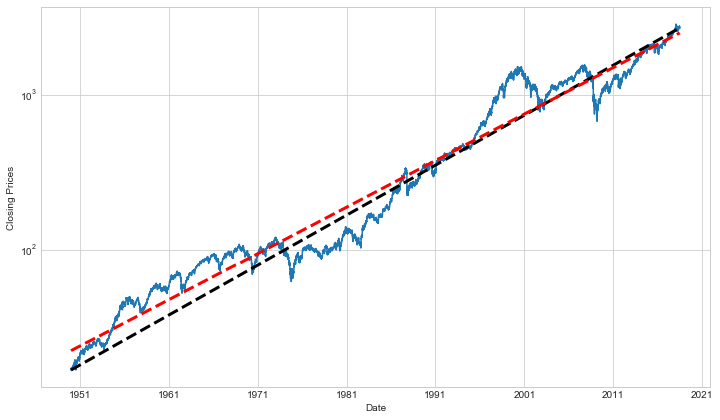

In [3]:
# Fit line to trend
x=np.arange(data.index.size)
fit = np.polyfit(x, np.log10(data['Adj Close'].values), 1)
linear_func = np.poly1d(fit)

# Get first and last values
time_values = [data.index[0], data.index[-1]]
y_values = [data['Adj Close'][0], data['Adj Close'][-1]]

# Plot log of SP-500 and trend lines
fig, ax = plt.subplots(1,1, figsize=(12,7))
ax.plot(data['Adj Close'])
ax.plot(time_values, y_values, 'k--', linewidth=3)
ax.plot(data.index, 10.**linear_func(x), 'r--', linewidth=3)
ax.set_yscale('log')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Prices')
ax.xaxis_date();

Sometimes trading "voodoo" can be misconstrued for trading wisdom.  A common adage that makes its way around investing circles is "sell in May and go away."  Ultimately, this implies there is seasonality within the market movements, meaning that there are repeating cycles that develop within the year.  Taking the last two decades, the trend and seasonality are easily decomposed with Python.  The figure below shows the raw data, the long-term trend determined by convolutional filtering, the seasonality determined by averaging periods (there are 252 trading days a year), and the residuals from the decomposition.  A multiplicative decomposition is used because the market behaves in this manner, i.e. percentage moves.  

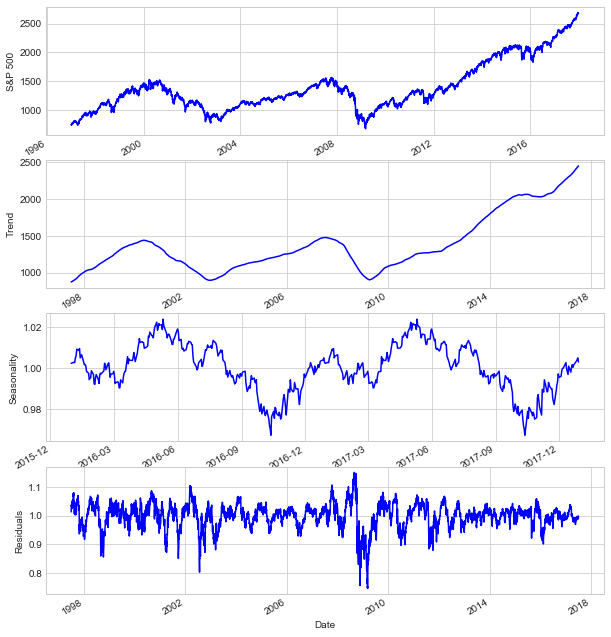

In [4]:
# Excise data for last two decades
data_seasonal = data.truncate(before='1996-12-31', after='2017-12-31')

# Perform seasonal decomposition
decomp = seasonal_decompose(data_seasonal['Adj Close'], model='multiplicative', freq=252)
trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

# Plot data
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(10,12))
data_seasonal['Adj Close'].plot(ax=ax1, style='b')
trend.plot(ax=ax2, style='b')
seasonal[-504:].plot(ax=ax3, style='b')
residual.plot(ax=ax4, style='b')
ax1.set_ylabel('S&P 500')
ax2.set_ylabel('Trend')
ax3.set_ylabel('Seasonality')
ax4.set_ylabel('Residuals');

Looking at the summer months, it actually looks like growth in this time period is quite strong.  Fall seems to be the weakest period, in fact, with a 4$\%$ relative decline against the underlying trend.  The residuals expose periods of large variability where the market reacts to specific events.  Delving deeply into the meaning of these individual features is beyond the scope of what I want to look at here, but we can still gain some insight by simple inspection.  The first noticable characteristic is that the largest deviations tend to be negative.  As a casual observer, I would interpret this as evidence that the market tends to over react to the downside as fear takes over the market.  Furthermore, they all tend to touch on the 10$\%$ decline level, the definition of a correction.  One might wonder if the forces dictating buying and selling are driven by the psychological significance of this defination... just an idea.  The second noticable behavior is the contrasting volitility in the dot com bubble and the housing crisis.  The dot com bubble unraveled much more slowly and the panic selling was less dramatic as it unfolded.  The housing crisis on the otherhand seemed to catch everyone off guard with how quickly it developed and its severity.  

Continuing with the search for seasonality, we can dive further into the typical monthly behavior by looking at the distributions of returns in a given month using box and wisker plots.

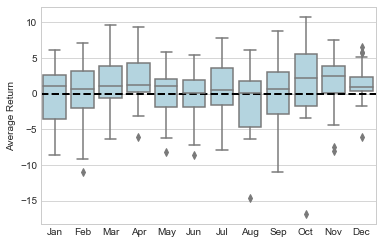

In [5]:
# Downsample to monthly intervals
by_month = data_seasonal['Adj Close'].resample('M', label='left').ffill()

# Calculate returns and aggregate
monthly_returns = by_month/by_month.shift(1)-1
monthly_returns = monthly_returns[1:]*100
# Reshape data into rows of year and columns of months
monthly_table = monthly_returns.values.reshape(monthly_returns.count()/12, 12)
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
monthly_df = pd.DataFrame(data=monthly_table, columns=months)

# Make plot
ax = sns.boxplot(data=monthly_df, color='lightblue')#, errwidth=0)
ax.axhline(y=0, linestyle='--', linewidth=2, color = 'k')
ax.set_ylabel('Average Return');

Box plots break the distributions into quartiles, with the filled box denoting the middle two quartiles and the protruding arms marking the outer quartiles.  Outliers, when present, are shown as "whiskers" with points.  Generally speaking, it appears the average returns (solid lines in boxes) are closer to zero in the summer months than in the rest of the year; however, there is still ample opportunity for gains.  The spring and fall tend to be the best times to invest.  The largest spread in the distribution is found in September, which backs up its reputation as an exceptionally volatile month.

Overall, it seems to me the wisdom found in selling in May and going away is good advice, except for when it isn't.  Bearing in mind we typically have the underlying trend working in our favor, it may be best to ride out any perceived seasonality since it isn't a reliable feature.  Regardless, if anyone wants to let me stay at their place in the Hamptons, I'm down to go away for a bit....

## Fitting and Forecasting

Working with time variability is tricky.  It is important to remember that every model is an approximation to the real system, and we must remain aware of its strengths and weakness when determining the utility in application.  For instance, we are attempting to describe the market statistically, and it will inevitably fail in times when shocking news comes out, at least temporarily.  Therefore, additional measures are needed to properly assess risk.  More technically,  these systems are influenced by their past behavior, so data points are not independent.  The effectiveness of modeling and forecasting price movements hinges on the assumption that the properties estimated by model parameters do not change with time. Care must also be taken to establish a timescale on which we want to consider the behavior.  Markets have a striking level of self-affinity, but the statistical properties will inevitably differ if either minute or daily changes are considered. 

We'll apply two approaches in our fitting.  The first actually fits the time variability and cummulative movement itself with an auto-regressive integrated moving average (ARIMA) model.  This allows for forecasting with a probabilistic estimate of the future trajectory.  In the second, we will use a support vector machine (SVM) to determine trading signals.  The goal is to come up with a classification scheme based on common conditions that lead to up or down moves.  With this, a trading strategy can be developed that re-evaluates the market as it evolves.

For both of these models, we will consider the market in weeklong intervals.  For the ARIMA model, we just need the dates and adjusted clsoing prices.  For the SVM classifier, we want basic stock data on a weekly timeframe so we need to downsample the data and get the weekly open, adjusted close, high, low, and total volume.  We will also calculate the volitility over a 20 trading day rolling window to derive an indicator like a Bollinger band to serve as a proxy for how far away the market is from its moving average.  Finally, we will only consider the last six years of the most recent bull run, taking time from the beginning of 2013 onwards for minimal stastical variability (although this criteria isn't completely met).

In [6]:
data['STD'] = data['Adj Close'].rolling(window=20).std()
fitting_data = data.resample('W-Mon', closed='left', label='left', loffset=7) \
                                .agg({'Open': lambda x: x[0],
                                      'Adj Close': lambda x: x[-1],
                                      'High' : max,
                                      'Low' : min,
                                      'Volume' : sum,
                                      'STD' : lambda x: x[-1],
                                    })  
fitting_data = fitting_data.truncate(before='2013-1-1')

## The ARIMA Model

For our exploratory analysis using an ARIMA model, we'll crudely divide the data into a training set before 2017 and a test set from 2017 until now against which we will compare predictions.

In [7]:
train = fitting_data['Adj Close'][:'2016']
test = fitting_data['Adj Close']['2017':]

Next, the model is fit using the SARIMAX package in Python.  To properly chose the hyperparameters, a grid search will be used.  However, we will ignore the seasonality here by setting those parameters to zero.  In testing, seasonality was allowed for, but was not found.  Since it significantly slows the fitting, it is best to ignore it henceforth.  Why then use the SARIMAX package since it fits a seasonal ARIMA?  Well... it has a larger supporting infrastructure than the ARIMA fit, for instance, that makes our modeling and evaluation easier.  

ARIMA models are defined by three hyperparameters that describe the number of lagged observations in the auto-regressive terms (p), the degree of differencing (d), and the moving average window (q).  The model with the lowest Akaike Information Criterion (AIC) will be chosen.  A general problem with machine learning algorithms is that while they are very powerful they can be prone to overfitting, and the ARIMA model is no exception.  Thus, the AIC is a useful measure of the goodness of fit because it provides the penalized likelihood so we can find the simplest model that fits well, rather than rewarding a model that simply memorizes the data.  

Fair warning: in the spirit of a quick exploration, we are going to fudge a bit in our fitting.  Ideally, you should fit with homoskedastic data where the amplitude of the RMS does not evolve.  Stock data, however, is heteroskedastic since the amplitude of variability scales with the price and with specific events.  In simple terms, a 1$\%$ fluctuation accounts for a larger value at the end of a bull run than at the beginning.  At a later date I'll add the additionaly machinery to deal with this.  The intent here is to just get the framework up and running for general application at a later date.

In [8]:
# Turn off warnings so the terminal doesn't get 
# filled when models fail to fit
warnings.filterwarnings("ignore")

# Establish range of parameters for p, d, and q
p = d = q = range(0, 5)

# Generate combinations of p, d and q triplets
param_list = list(itertools.product(p, d, q))
p = d = q = range(0, 1)

# Generate combinations of seasonal p, d and q triplets
s_param_list = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

# Initialize variables to put fit output
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
test_model = None
SARIMA_model = None

#Loop through parameter combinations
for params in param_list:
    #Loop through seasonal parameters
    for params_seasonal in s_param_list:
        # Fit model
        try:
            test_model = sm.tsa.statespace.SARIMAX(train,
                                            order=params,
                                            seasonal_order=params_seasonal)
            
            result = test_model.fit()
            
            #Save results
            if result.aic < best_aic:
                best_aic = result.aic
                best_pdq = params
                best_seasonal_pdq = params_seasonal
                SARIMA_model = test_model
        
        #Catch exceptions in the event of a failure
        except:
            continue

print 'Model Paramters = ', best_pdq, \
      'Seasonal Paramters = ', best_seasonal_pdq, \
      'AIC = ', best_aic

Model Paramters =  (3, 2, 3) Seasonal Paramters =  (0, 0, 0, 52) AIC =  2018.1225671898092


The market seems to care about the occurances on a month long timescale with p and q values of 3, meaning it knows about what happened three intervals, or 4 weeks, prior.  With these parameters, we can fit the data to get parameter coefficients and significances.

In [9]:
weekly_fit = SARIMA_model.fit()
print weekly_fit.summary()

                           Statespace Model Results                           
Dep. Variable:              Adj Close   No. Observations:                  208
Model:               SARIMAX(3, 2, 3)   Log Likelihood               -1002.061
Date:                Sun, 01 Jul 2018   AIC                           2018.123
Time:                        20:45:21   BIC                           2041.418
Sample:                    01-07-2013   HQIC                          2027.544
                         - 12-26-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4448      0.150     -2.975      0.003      -0.738      -0.152
ar.L2         -0.7930      0.139     -5.699      0.000      -1.066      -0.520
ar.L3         -0.2372      0.084     -2.823      0.0

There are several things worth mentioning about the fit.  All of the parameters are significant, i.e. probabilities are below 0.05.  The residuals indicate that this is indeed a good fit.  A Ljung-Box test finds that the residuals are uncorrelated (high probability the autocorrelation is consisitent with 0).  As expected, heteroskedacsticity is an issue in the residuals, due in part to the over reaction of the market during certain events, compounded with us using data that has a multiplicative dependence.  The JB test tells us the residuals cannot be described by a Gaussian and the skewness (third moment of the distribution) and kurtosis (fourth moment of the distribution) indicates there is an asymmetric tail to negative values and the distribution is sharper than a normal distribution.  Plotting the residuals and their histogram, quantile plot, and autocorrelation confirms all of these diagnostics.

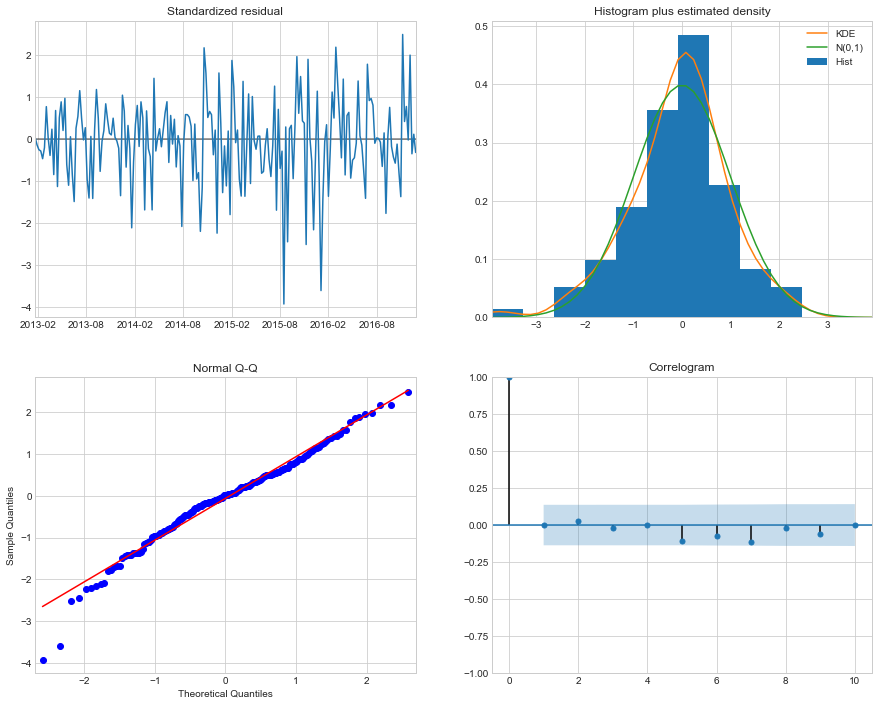

In [10]:
ax = weekly_fit.plot_diagnostics(figsize=(15, 12))

Nevertheless, let's proceed with forecasting the next year based on our model.  Overall, does a decent job.  The forecast gets the direction correct and the outer confidence intervals bound the market fluctuations.  Towards the end of last year and the very beginning of this year the upwards slope of the market sharply increased, but it has since returned to parallel close to our average prediction.

In [11]:
predictions = weekly_fit.get_prediction(test.index[0], 
                          test.index[-1],
                          dynamic=True)
predictions_confidence = predictions.conf_int()

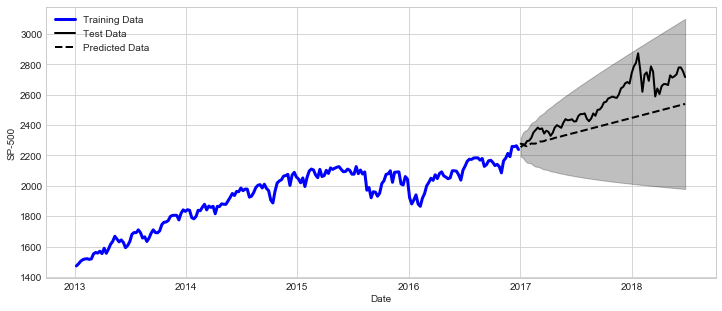

In [12]:
fig, ax = plt.subplots(1,1, figsize=(12, 5))
ax.plot(train, '-', color = 'blue', linewidth=3, label='Training Data')
ax.plot(test, '-', color = 'black', linewidth=2, label = 'Test Data')
ax.plot(predictions.predicted_mean, 
        '--', 
        color = 'black', 
        linewidth=2, 
        label = 'Predicted Data')
ax.fill_between(predictions_confidence.index, 
                predictions_confidence.iloc[:, 0], 
                predictions_confidence.iloc[:, 1], 
                color='black', alpha=.25);

ax.set_xlabel('Date')
ax.set_ylabel('SP-500')
plt.legend(loc='upper left');

## Signal Determination

Instead of trying to project trends into the future, we can also look for signals that may lead price movements.  When markets have advanced rapidly, there is a tendancy to take profits.  Similarly, following a steep sell off, some people may see buying opportunities.  Traders have developed numerous indicators to try to quantify the market environment and produce metrics that indicate when conditions are favorable for either up or down moves.  Here, we will derive a few quantities that will be fed into a support vector machine classifer to determine combinations of variables precede increases or decreases in the next week.  The idea is that we want to make a maximum of one trade every week right at the open based off of the conditions in the prior week.  With this indicator, you could imagine making a trading plan where you either invest in the market or short it.

All of these are relative values to normalize away any dependence on the actual market value and time trends.  The variables we will consider and their significance are:

 - High Percentage - The high price point in a week compared to its close. Could it hold gains?
 - Low Percentage - The low price point in a week compared to its close.  Did it rally off lows or settle at the low point?
 - Percent Change - Percentage change from last week's open to close. How much did the market gain or lose last week?
 - Volume - Total volume normalized by the 4-week averaged volume.  Is the volume higher or lower than it has been recently?
 - Monthly Percentage - 4 week returns.  Are we in an up or down trend?  Note- This does introduce some correlation within the input we might be wary of.
 - Deviation- Fractional distance from the moving average at the open compared to the standard deviation.  Are we at an extreme high or low point?

In [13]:
SVR_data = fitting_data.copy()

# Calculate variables
SVR_data['High Pct'] = (SVR_data['High']/SVR_data['Open']-1.)*100.
SVR_data['Low Pct'] = (SVR_data['Low']/SVR_data['Open']-1.)*100.
SVR_data['Pct Change'] = (SVR_data['Adj Close']/SVR_data['Open']-1.0)*100.
SVR_data['Volume'] = SVR_data['Volume']/SVR_data['Volume'].rolling(window=4).mean()
SVR_data['Monthly Pct'] = (SVR_data['Adj Close'][3:]/SVR_data['Open'][:-3].values \
                               -1.)*100.
SVR_data['Deviation'] = (SVR_data['Open']-SVR_data['Open'].rolling(window=4).mean())/SVR_data['STD']

# Shift over to align with value we seek to predict
shift_columns = ['Volume', 'High Pct', 'Low Pct', 'Monthly Pct']
SVR_data[shift_columns] = SVR_data[shift_columns].shift(1)
SVR_data = SVR_data[4:]

# Make column with binary True/False of whether the market increased or decreased
SVR_data['Pos'] = SVR_data['Pct Change'] > 0.0

With an SVM, the idea is to establish classification criteria based on the maximum seperation between distributions between the classes.  For flexibility, we will use a radial basis function kernel which can learn arbitrarily complex functions.  To ensure we are fitting and testing on comparable samples, we will shuffle the data.  There are two hyperparameters we must determine: the regularization parameter (C) and the kernel coefficient parameter ($\gamma$).  Basically, C allows for soft margins so the model does not overfit an introduce small bumps and wiggles in the decision boundaries and smooths the fine detail.  Typically, models with smoother boundaries generalize better, but of course some of the features may be real, so too generous a cost function loses predictive power.  SVMs make their decisions by considering points near the decision boudary.  By changing $\gamma$, the weighting of more distant points changes which alters the ability to capture detail near the boundary.  Again, this comes at the cost of predictive power if you are too generous.

In [14]:
# Set classifier
classifier = SVC(kernel = 'rbf')

# Remove data columns that aren't features
predictors = SVR_data.columns.tolist()
predictors = [p for p in predictors if p not in ['Date',
                                                 'High', 
                                                 'Open', 
                                                 'Low', 
                                                 'Close',
                                                 'STD',
                                                 'Pct Change',
                                                 'Adj Close']]

# Shuffle and split data into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(SVR_data[predictors], 
                                                    SVR_data['Pos'], 
                                                    test_size=0.5,
                                                    shuffle=True,
                                                    random_state=1)

# Make hyperparameter grid
grid = {"C": uniform(2, 1000),
         "gamma": uniform(0.1, 5)}

# Setup kfold and run grid search
kfold = KFold(n_splits=3, random_state=0)
cv_svc = RandomizedSearchCV(estimator = classifier,
                            param_distributions = grid,
                            n_iter = 10,
                            cv = kfold,
                            random_state = 1,
                            n_jobs = -1)

# Fit with optimized parameters
svc_fit = cv_svc.fit(X_train, y_train)

# Make predictions
predictions = svc_fit.predict(X_test)

# Join data and output for a tidy dataset for diagnostics
output_data = X_test
output_data['Pct Change'] = SVR_data['Pct Change']
output_data['Pos'] = y_test
output_data['Prediction'] = predictions

Now that we have our model and predictions, let's see how we did.  I like to use a number of different metrics because they all tell a different story about the performance.

In [15]:
# Calcuate various diagnostics to establish model quality
print 'Accuracy Score = ', metrics.accuracy_score(y_test, predictions)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()
print 'True Neg = ', tn, '   False Pos = ', fp,'   False Neg = ', fn, '   True Pos = ', tp
print metrics.classification_report(y_test, predictions)

Accuracy Score =  0.9574468085106383
True Neg =  50    False Pos =  4    False Neg =  2    True Pos =  85
             precision    recall  f1-score   support

      False       0.96      0.93      0.94        54
       True       0.96      0.98      0.97        87

avg / total       0.96      0.96      0.96       141



This model does incredibly well and better than I thought it would (and possibly better than I believe).  Most of the misclassifications are false positives where the classifier predicted the market would go up, but it actually decreased.  Let's look at the misclassifications a bit.

In [16]:
print output_data[output_data['Pos'] != output_data['Prediction']]

              Volume  High Pct   Low Pct  Monthly Pct  Deviation    Pos  \
Date                                                                      
2015-08-31  1.292996  1.441618 -4.994021    -5.493967  -0.551508  False   
2014-10-13  1.123046  0.397458 -3.246682    -4.023586  -1.318248  False   
2018-03-12  0.974490  3.935384 -0.198058     5.681997   1.746932  False   
2014-01-27  1.025478  0.448658 -2.757123    -2.779298  -1.391886  False   
2015-11-16  0.989824  0.000000 -3.555350    -0.427711  -2.104672   True   
2016-03-07  1.125456  3.184174 -0.786796     6.765781   1.486094   True   

            Pct Change  Prediction  
Date                                
2015-08-31   -3.297379        True  
2014-10-13   -0.991264        True  
2018-03-12   -1.380737        True  
2014-01-27   -0.471241        True  
2015-11-16    3.317869       False  
2016-03-07    1.306539       False  


A quick Google search suggests that these were unusual times.  During the week of October 13, 2014, the market had to contend with the Ebola scare that was shaking the nation coupled with a technical breakdown of the market closing below the 200 day moving average, a level that is often taken as a sign of long-term support.  During the week of August 31, 2015 the market was dealing with the possiblity of a rate hike by the Federal Reserve which came at the end of a 6$\%$ monthly decline and a 12.5% decline from all-time highs.  The surprise gains in March 12, 2016 came the same week that the FBI announced it was not going to press charges against Presidential candidate Clinton in the email investigation.  Finally, the March 12, 2018 misclassification may be tied to steel and aluminum import tariffs as the market grappled with the threat of a possible trade war.  This concern still lingers today.

## Summary

Here, I've shared a bit of analysis of the S&P 500.  We've looked at the long term market trends and seasonality.  Taking a critical look at the mantra "sell in May and go away," it looks like it may not be the best advice.  There may be a little bit of truth, but over 50$\%$ of the time the index is up during those months, so opting to stay out of market participation is detrimental to overall returns.  We also fit an ARIMA model and found it did an okay job, despite it being an incomplete treatment where the heteroskedicity was removed.  We also used and SVM to develop a model to predict up or down weeks based off of basic market data which was remarkably accurate.  Both of these models need further evalution with a "walk forward" validation before they can actually be used in a trading system.  Given the encouraging results from this quick look at the market, I plan to pursue this project more in the future.  Check back for developments!